# Bank Customer Churn Prediction
***
## Table of Contents
1. [Introduction](#1-introduction)
1. [Loading Data](#2-loading-data)
1. [Exploratory Data Analysis](#3-exploratory-data-analysis)
1. [Data Preprocessing](#4-data-preprocessing)
    - [Handling Categorical Features](#handling-categorical-features)
    - [Standardisation](#standardisation)
1. [Predictive Modelling](#5-predictive-modelling)
    - [Hyperparameter Tuning](#hyperparameter-tuning)
    - [Evaluation on Test Data](#evaluation-on-test-data)
1. [Conclusion](#6-conclusion)
1. [References](#7-references)
***

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pandas.api.types import is_numeric_dtype

## 1. Introduction
In today's highly competitive banking sector, customer retention plays a crucial role for sustained growth and profitability. Predicting customer churn allows institutions to proactively address issues and improve customer satisfaction. 

The objective of this project is to develop and compare multiple predictive models to identify customers who are at risk of churning, enabling the bank to implement targeted retention strategies.

## 2. Loading Data
The dataset used in this project (retrieved from [Kaggle - Churn Modelling](https://www.kaggle.com/datasets/shrutimechlearn/churn-modelling)) contains customer information from a multinational bank, as detailed below:

- **RowNumber**: Row Numbers from 1 to 10000.
- **CustomerId**: Unique Ids for bank customer identification.
- **Surname**: Customer's last name.
- **CreditScore**: Credit score of the customer.
- **Geography**: The country from which the customer belongs.
- **Gender**: Male or Female.
- **Age**: Age of the customer.
- **Tenure**: Number of years for which the customer has been with the bank.
- **Balance**: Bank balance of the customer.
- **NumOfProducts**: Number of bank products the customer is utilising.
- **HasCrCard**: Binary Flag for whether the customer holds a credit card with the bank or not.
- **IsActiveMember**: Binary Flag for whether the customer is an active member with the bank or not.
- **EstimatedSalary**: Estimated salary of the customer in Dollars.
- **Exited**: Binary flag 1 if the customer closed account with bank and 0 if the customer is retained.

In [2]:
df = pd.read_csv("_datasets/bank_customer_churn_records.csv")
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


The first three features (`RowNumber`, `CustomerId` and `Surname`) are not required for predictions.

In [3]:
df = df.drop(columns=["RowNumber", "CustomerId", "Surname"])

In [4]:
df.shape

(10000, 11)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


In [6]:
df.isnull().sum()

CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

## 3. Exploratory Data Analysis

In [7]:
def plot_correlation_matrix(df: pd.DataFrame, method="pearson", annot=True) -> None:
    num_columns = df.select_dtypes(include="number")
    plt.figure(figsize=(12, 8))
    corr = num_columns.corr(method=method)
    sns.heatmap(corr, annot=annot, fmt=".2f", cmap="coolwarm", square=True)
    plt.title(f"{method.title()} Correlation Matrix", fontsize=12)
    plt.xticks(rotation=45, ha="right")
    plt.yticks()
    plt.tight_layout()
    plt.show()

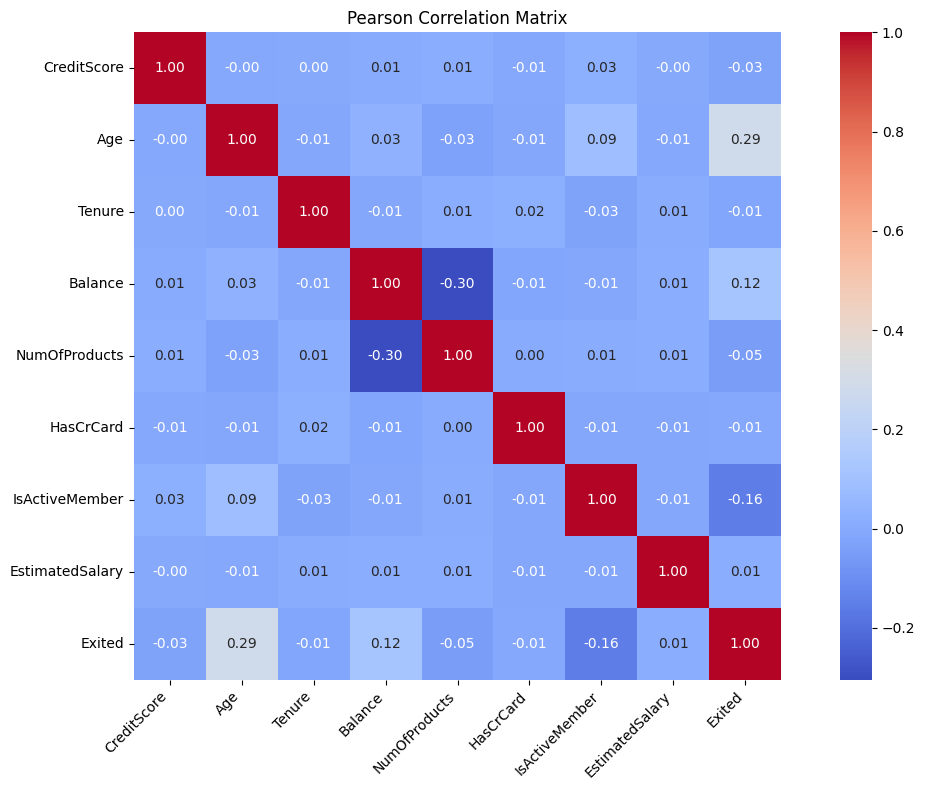

In [8]:
plot_correlation_matrix(df)

In [9]:
def plot_distributions(df: pd.DataFrame) -> None:
    n_cols = df.shape[1]
    fig, axes = plt.subplots(4, 4, figsize=(20, 12))
    axes = axes.flatten()

    for i, col in enumerate(df.columns):
        ax = axes[i]
        if is_numeric_dtype(df[col]) and i not in [
            6,
            7,
            8,
            10,
        ]:  # Numeric except i == 6, 7, 8, 10 -> Histogram
            sns.histplot(df[col], kde=True, ax=ax, edgecolor="black")
            ax.set_title(f"Distribution of {col}")
        else:  # Categorical -> Count plot
            sns.countplot(
                data=df,
                x=col,
                ax=ax,
                hue=col,
                palette="Set2",
                edgecolor="black",
            )
            ax.set_title(f"Count of {col}")

    if n_cols < len(axes):
        for j in range(n_cols, len(axes)):
            plt.delaxes(axes[j])
    plt.tight_layout()
    plt.show()

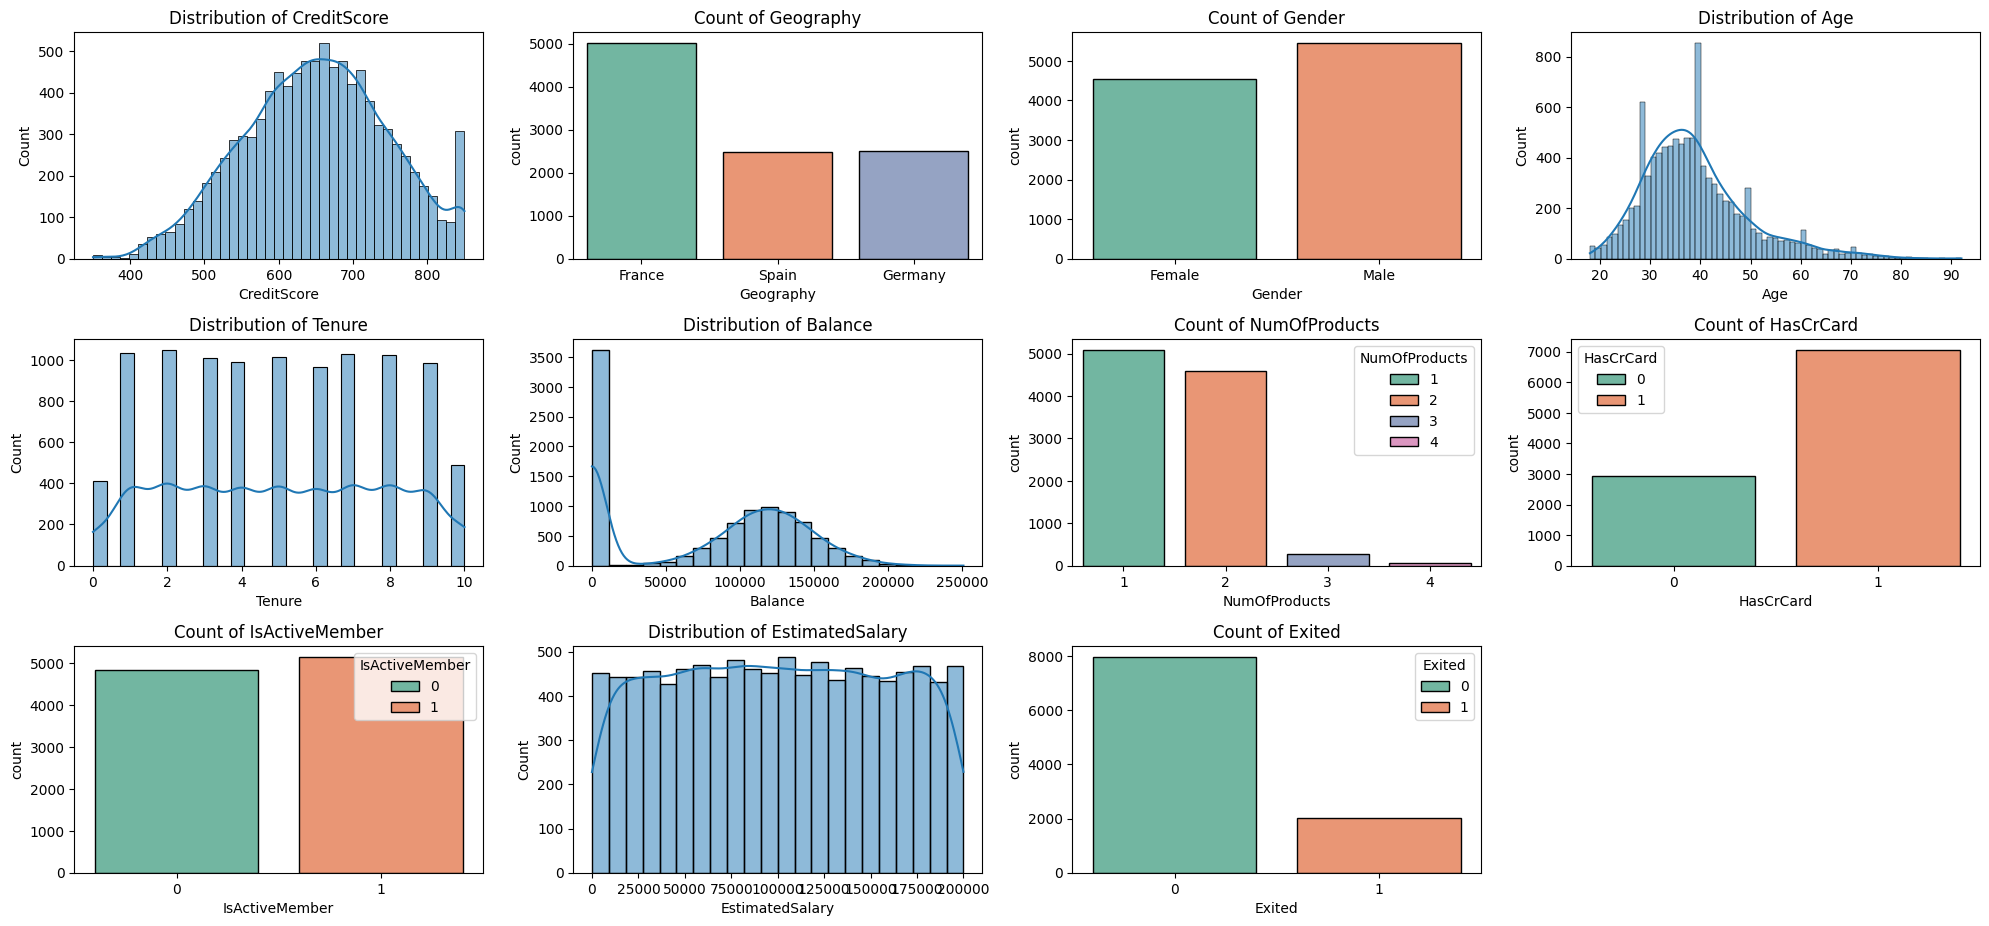

In [10]:
plot_distributions(df)

The imbalance of the target value may result in poor predictive performance, especially for minority class. To address this issue, we can either **oversample the minority class** or **undersamble the majority class** during training process. 

## 4. Data Preprocessing

### Handling Categorical Features
Encoding Categorical Features:
- **Gender**: Label Encoding (female = $0$, male = $1$).
- **Geography**: One-Hot Encoding.

In [11]:
df["Gender"] = df["Gender"].map({"Female": 0, "Male": 1})
df = pd.get_dummies(df, columns=["Geography"])
df.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain
0,619,0,42,2,0.00,1,1,1,101348.88,1,True,False,False
1,608,0,41,1,83807.86,1,0,1,112542.58,0,False,False,True
2,502,0,42,8,159660.80,3,1,0,113931.57,1,True,False,False
3,699,0,39,1,0.00,2,0,0,93826.63,0,True,False,False
4,850,0,43,2,125510.82,1,1,1,79084.10,0,False,False,True


### Standardisation
Some machine learning models, such as Linear Regression (especially with regularisation), K-Nearest Neighbours (KNN), and Support Vector Machines (SVM), are sensitive to the scale of input features because they compute distances or rely on dot products. Therefore, feature scaling is essential to ensure fair contribution of each feature and to avoid biased results.

Standardisation is generally preferred for most algorithms when features are normally distributed or when using regularised models. Normalisation would be useful if the data are not Gaussian or when we want all features strictly in the same range (e.g., for neural networks)

- Scale all numerical features (including boolean features).
- Always fit the scaler **only on training features** (X_train) and use it to transform test features (X_test).
- `.fit_transform(X_train)` and `.transform(X_test)`
- Do not scale the target variable unless there is a specific reason.
    - If the target variable needs to be scaled, invert the transformation before interpreting results.


This process will be included in Pipeline.

## 5. Predictive Modelling
For this regression tasks, the following six regressors will be compared and evaluted:
- Logistic Regression
- K-Nearest Neighbour Classifier
- Gaussian Naive Bayes Classifier
- Decision Tree Classifier
- Random Forest Classifier
- XGBoost Classifier

In [12]:
from sklearn.model_selection import train_test_split, StratifiedKFold


X = df.drop(columns=["Exited"])
y = df["Exited"]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
)

### Hyperparameter Tuning
Optimisation of hyperparameters is essential to obtain the best performance from machine learning models. **Grid Search** or **Random Search** is typically used to find the best hyperparameters with cross-validation.

We use the stratified K-Fold cross-validator `StratifiedKFold()`. With this approach, each fold maintains approximately the same percentage of samples for each class as found in the original dataset. This technique is especially suitable for classification problems with imbalanced classes, preventing bias caused by random splitting and ensuring fair evaluation of all classes.

Instead of manually repeating the hyperparameter tuning process for each model under evaluation, we can employ a `Pipeline` to automate the entire workflow. A pipeline establishes a structured sequence for data preprocessing, model building, and evaluation. This approach enables us to modularise the machine learning process, making it significantly more efficient and scalable.

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

In [14]:
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=10000, random_state=42),
    "KNN": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(eval_metric="logloss", random_state=42),
}

param_grids = {
    "Logistic Regression": {
        "clf__C": [0.01, 0.1, 1, 10, 100],
        "clf__solver": ["lbfgs", "liblinear"],
        "clf__penalty": ["l2"],
    },
    "KNN": {
        "clf__n_neighbors": [3, 5, 7, 9, 12],
        "clf__weights": ["uniform", "distance"],
        "clf__metric": ["euclidean", "manhattan"],
    },
    "Naive Bayes": {},
    "Decision Tree": {
        "clf__max_depth": [None, 5, 10, 20],
        "clf__min_samples_split": [2, 5, 10],
        "clf__criterion": ["gini", "entropy"],
    },
    "Random Forest": {
        "clf__n_estimators": [50, 100, 200],
        "clf__max_depth": [None, 5, 10, 20],
        "clf__min_samples_split": [2, 5, 10],
        "clf__max_features": [None, "sqrt", "log2"],
    },
    "XGBoost": {
        "clf__n_estimators": [50, 100, 200],
        "clf__max_depth": [3, 5, 7],
        "clf__learning_rate": [0.01, 0.1, 0.2],
        "clf__subsample": [0.6, 0.8, 1.0],
        "clf__colsample_bytree": [0.6, 0.8, 1.0],
    },
}

As mentioned in [3. Exploratory Data Analysis](#3-exploratory-data-analysis), the target variable shows class imbalance, which may result in misleading performance metrics. To address this, we employ the **Synthetic Minority Oversampling Technique** (SMOTE), which generates synthetic samples for the minority class by interpolating between existing minority instances. This approach reduces overfitting compared to simple duplication.

SMOTE is an oversampler from the imbalanced-learn library, and while it does implement the necessary methods, it is not compatible with `sklearn.pipeline.Pipeline`. Instead, `imblearn.pipeline.Pipeline` must be used to work with samplers in `imblearn`.

In [15]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE


def find_best_estimators(classifiers, X_train, y_train, n_splits=5):
    best_estimators = {}
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    for name, clf in classifiers.items():
        print(f"\n===== {name} =====")
        pipeline = Pipeline(
            [
                ("scaler", StandardScaler()),
                ("smote", SMOTE(random_state=42)),
                ("clf", clf),
            ]
        )  # StandardScaler + SMOTE + classifier
        param_grid = param_grids[name]
        grid = GridSearchCV(
            estimator=pipeline, param_grid=param_grid, scoring="f1", cv=skf, n_jobs=-1
        )
        grid.fit(X_train, y_train)
        print(f"Best hyperparameters for {name}: {grid.best_params_}")
        print(f"Best mean cross-validated F1-score: {grid.best_score_:.4f}")
        best_estimators[name] = grid.best_estimator_
    return best_estimators

In [16]:
best_estimators = find_best_estimators(
    classifiers=classifiers, X_train=X_train, y_train=y_train
)


===== Logistic Regression =====
Best hyperparameters for Logistic Regression: {'clf__C': 10, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}
Best mean cross-validated F1-score: 0.4921

===== KNN =====
Best hyperparameters for KNN: {'clf__metric': 'manhattan', 'clf__n_neighbors': 12, 'clf__weights': 'uniform'}
Best mean cross-validated F1-score: 0.5474

===== Naive Bayes =====
Best hyperparameters for Naive Bayes: {}
Best mean cross-validated F1-score: 0.5126

===== Decision Tree =====
Best hyperparameters for Decision Tree: {'clf__criterion': 'gini', 'clf__max_depth': 5, 'clf__min_samples_split': 2}
Best mean cross-validated F1-score: 0.5747

===== Random Forest =====
Best hyperparameters for Random Forest: {'clf__max_depth': 10, 'clf__max_features': 'sqrt', 'clf__min_samples_split': 10, 'clf__n_estimators': 200}
Best mean cross-validated F1-score: 0.6117

===== XGBoost =====
Best hyperparameters for XGBoost: {'clf__colsample_bytree': 1.0, 'clf__learning_rate': 0.1, 'clf__max_depth': 3,

### Evaluation on Test Data

In [17]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
)


def evaluate_classifier(model, X_test, y_test):
    y_pred = model.predict(X_test)
    acc = round(accuracy_score(y_test, y_pred), 4)
    pre = round(precision_score(y_test, y_pred), 4)
    rec = round(recall_score(y_test, y_pred), 4)
    f1 = round(f1_score(y_test, y_pred), 4)
    roc_auc = round(roc_auc_score(y_test, y_pred), 4)
    return {
        "Accuracy": acc,
        "Precision": pre,
        "Recall": rec,
        "F1-Score": f1,
        "ROC-AUC": roc_auc,
    }

In [18]:
best_model_log_reg = best_estimators["Logistic Regression"]
best_model_knn = best_estimators["KNN"]
best_model_nb = best_estimators["Naive Bayes"]
best_model_dt = best_estimators["Decision Tree"]
best_model_rf = best_estimators["Random Forest"]
best_model_xgb = best_estimators["XGBoost"]

In [19]:
results_log_reg = evaluate_classifier(best_model_log_reg, X_test, y_test)
results_knn = evaluate_classifier(best_model_knn, X_test, y_test)
results_nb = evaluate_classifier(best_model_nb, X_test, y_test)
results_dt = evaluate_classifier(best_model_dt, X_test, y_test)
results_rf = evaluate_classifier(best_model_rf, X_test, y_test)
results_xgb = evaluate_classifier(best_model_xgb, X_test, y_test)

In [20]:
results_df = pd.DataFrame(
    [results_log_reg, results_knn, results_nb, results_dt, results_rf, results_xgb],
    index=[
        "Logistic Regression",
        "KNN",
        "Naive Bayes",
        "Decision Tree",
        "Random Forest",
        "XGBoost",
    ],
)
print(results_df)

                     Accuracy  Precision  Recall  F1-Score  ROC-AUC
Logistic Regression    0.7210     0.3859  0.7099    0.5000   0.7168
KNN                    0.7645     0.4311  0.6209    0.5089   0.7102
Naive Bayes            0.7360     0.4012  0.6972    0.5093   0.7213
Decision Tree          0.7975     0.4883  0.6387    0.5535   0.7375
Random Forest          0.8260     0.5447  0.6972    0.6116   0.7773
XGBoost                0.8575     0.6330  0.6539    0.6433   0.7806


## 6. Conclusion

A comparative analysis of six different preditive models applied to the bank customer churn dataset yields the following key insights:

- **XGBoost** achieved the highest scores across all the evaluation metrics, demonstrating its superior predictive capability for customer churn.
- **Random Forest** ranked second with the second highest accuracy, precision, F1-score and ROC-AUC, closely after XGBoost.
- Simpler models such as **Logistic Regression** and **Naive Bayes** had noticeably lower precision and F1-scores, though their recall remains relatively high.
- Precision is consistently lower than recall, reflecting the difficulty of accurately identifying true churners without excessive false positives.
- In practical appliations, modern e-commerce prediction models for example, can typically achieve accuracy rates between 70% and 90% with F1-scores and ROC-AUC values above 0.6 - 0.7. These industrial benchmarks align well with the observed results in this analysis.


## 7. References

1. Jeremy Silva. (2020). *Predicting and Preventing the Churn of High Value Customers Using Machine Learning*.<br>
https://towardsdatascience.com/predicting-and-preventing-the-churn-of-high-value-customers-using-machine-learning-adbb4a61095d/

1. Ryan Kane. (2025). *Predicting Customer Churn: How To Build A Game-Changing Churn Prediction Model*.<br>
https://thecxlead.com/customer-experience-management/predicting-customer-churn-how-to-build-a-game-changing-churn-prediction-model/

1. 50 FOLDS. (n.d.). *Churn Prediction Accuracy*. <br>
https://www.alexanderjarvis.com/what-is-churn-prediction-accuracy-in-ecommerce/